In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.5 MB/s eta 0:00:00


In [2]:
!pip install wordcloud
!pip install textblob

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
df = pd.read_csv('./spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().any()


np.False_

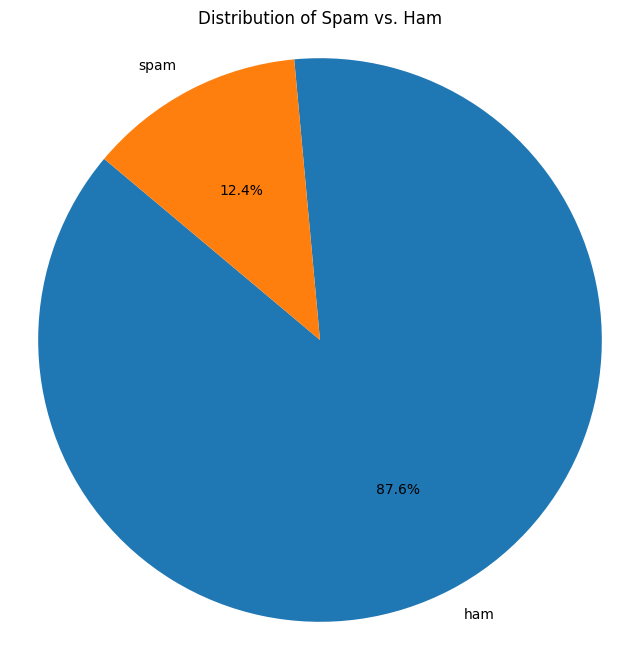

In [9]:
category_counts = df['Category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')
plt.show()

# TEXT VISUALIZATION

- Iterate through unique categories: This loop iterates through each unique category in the 'Category' column of the DataFrame df.¶
- Filter the DataFrame for the current category: Inside the loop, the code filters the DataFrame df to create a new DataFrame filtered_df containing only the rows where the 'Category' column matches the current category.
- Concatenate all text data for the current category: The code then concatenates all the text data from the 'Message' column of filtered_df into a single string variable named text.
- Generate word cloud: Using the concatenated text data (text), the code generates a word cloud using the WordCloud module. The word cloud is configured to have a width of 800 pixels, a height of 400 pixels, and a white background.
- Plot the word cloud: Finally, the code plots the generated word cloud using Matplotlib. Each word's size in the word cloud is proportional to its frequency in the concatenated text data. The title of each word cloud plot includes the current category being processed. The plt.axis('off') command is used to hide the axes of the plot.
This process repeats for each unique category, generating a separate word cloud for each category based on the text data associated with that category.

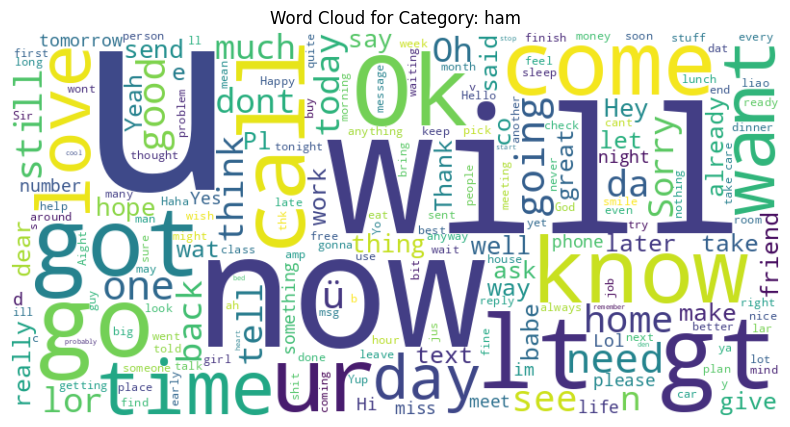

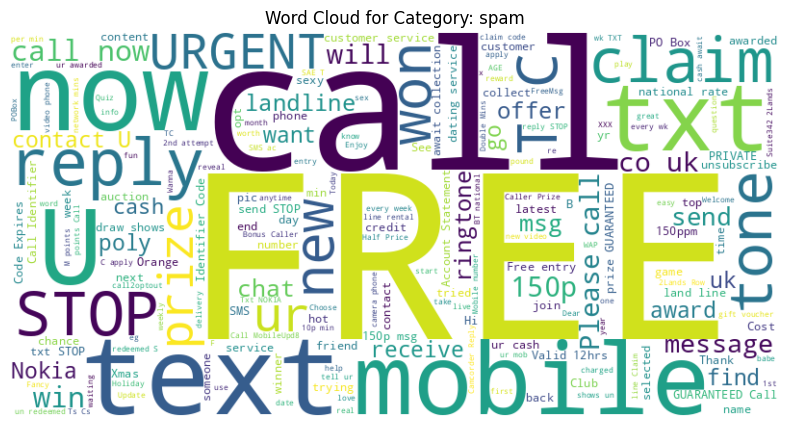

In [11]:
for category in df['Category'].unique():
    filtered_df = df[df['Category'] == category]

    text = ' '.join(filtered_df['Message'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

In [12]:
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Text Preprocessing

1. Lower Casing¶
2. Remove Extra White Spaces
3. Remove HTML Tags
4. Remove URLs
5. Remove Punctuations
6. Remove Special Characters
7. Remove Numeric Values
8. Remove Non-alpha Numeric

10. Handling StopWords¶
11. Handling Emojis
12. Stemming



In [13]:
df['Message'] = df['Message'].str.lower()

In [14]:
df['Message'] = df['Message'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [15]:
def remove_html_tags(text):
    if pd.isna(text):
        return text
    return BeautifulSoup(text, "html.parser").get_text()

df['Message'] = df['Message'].apply(remove_html_tags)

In [16]:
def remove_urls(text):
    if pd.isna(text):
        return text
    return re.sub(r'http\S+|www\.\S+', '', text)

df['Message'] = df['Message'].apply(remove_urls)

In [17]:
def remove_special_characters(text):
    if pd.isna(text):
        return text
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

df['Message'] = df['Message'].apply(remove_special_characters)

In [18]:
def remove_numeric(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text

df['Message'] = df['Message'].apply(remove_numeric)

In [19]:
def remove_non_alphanumeric(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Message'] = df['Message'].apply(remove_non_alphanumeric)

In [20]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [21]:
def replace_chat_words(text):
    if not isinstance(text, str):
        return text

    words = text.split()
    replaced_words = [chat_words.get(w.lower(), w) for w in words]
    return " ".join(replaced_words)

df['Message'] = df['Message'].apply(replace_chat_words)

In [22]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['Message'] = df['Message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def remove_emojis(text):
    return emoji.demojize(text)

df['Message'] = df['Message'].apply(remove_emojis)

In [24]:
porter_stemmer = PorterStemmer()

df['Message_stemmed'] = df['Message'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
df.head()

,Category,Message,Message_stemmed
0,0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,0,ok lar joking wif u oni,ok lar joke wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...,free entri wkli comp win fa cup final tkt st m...
3,0,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,0,nah dont think goes usf lives around though,nah dont think goe usf live around though


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=42)

In [40]:
X_train, X_test , y_train, y_test_count = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_count = cv.fit_transform(X_train)
X_test_count = cv.transform(X_test)

In [37]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [38]:
ypred_count = model.predict(X_test_count)

In [27]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.class_priors = {}
        for c in self.classes:
            self.class_priors[c] = np.log(np.sum(y == c) / n_samples)

        self.likelihoods = {}
        for c in self.classes:
            X_c = X[y == c]
            feature_count = np.sum(X_c, axis=0) + self.alpha
            total_count = np.sum(feature_count)
            self.likelihoods[c] = np.log(feature_count / total_count)

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                log_prior = self.class_priors[c]
                log_likelihood = np.sum(x * self.likelihoods[c])
                posteriors[c] = log_prior + log_likelihood
            y_pred.append(max(posteriors, key=posteriors.get))
        return np.array(y_pred)


In [28]:
clf_count = NaiveBayes()
clf_count.fit(X_train, y_train)

In [41]:
ypred_count = clf_count.predict(X_test)
accuracy_score(y_test_count, ypred_count)

0.9718992248062015

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       896
           1       0.90      0.89      0.89       136

    accuracy                           0.97      1032
   macro avg       0.94      0.94      0.94      1032
weighted avg       0.97      0.97      0.97      1032

Axes(0.125,0.11;0.62x0.77)


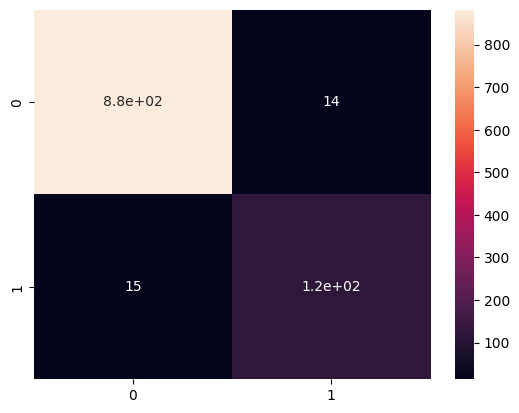

In [42]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, ypred_count))
print(sns.heatmap(confusion_matrix(y_test, ypred_count), annot=True))

In [43]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']

In [44]:
X_train, X_test , y_train, y_test_tf = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [45]:
clf_tf = NaiveBayes()
clf_tf.fit(X_train, y_train)

In [46]:
ypred_tf = clf_tf.predict(X_test)
accuracy_score(y_test_tf, ypred_tf)

0.9622093023255814

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       896
           1       0.99      0.72      0.83       136

    accuracy                           0.96      1032
   macro avg       0.97      0.86      0.91      1032
weighted avg       0.96      0.96      0.96      1032

Axes(0.125,0.11;0.62x0.77)


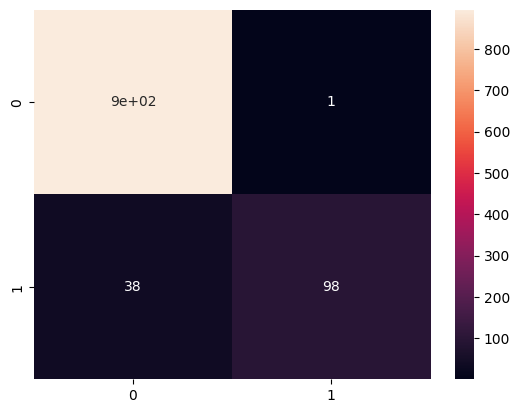

In [47]:
print(classification_report(y_test, ypred_tf))
print(sns.heatmap(confusion_matrix(y_test, ypred_tf), annot=True))

In [48]:
class LogisticRegression:
    def __init__(self, lr=0.01, k = 0.01):
        self.lr = lr
        self.k = 0.002

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def hypothesis(self, X, w, w0):
        return self.sigmoid(np.dot(X, w) + w0)

    def loss(self, X, w, w0, y):
        ypred = self.hypothesis(X, w, w0)
        eps = 1e-9
        return -np.mean(y*np.log(ypred + eps) + (1-y)*np.log(1-ypred + eps)) + self.k * np.sum(w**2)

    def gradientDescent(self, X, y, lr=0.01, epochs=100):
        w = np.zeros(X.shape[1])
        w0 = 0
        self.loss_e = [self.loss(X, w, w0, y)]

        for e in range(epochs):
            ypred = self.hypothesis(X, w, w0)

            dw = np.dot(X.T, (ypred - y)) / len(y)
            dw0 = np.sum(ypred - y) / len(y)

            dw +=  self.k * w

            w -= lr * dw
            w0 -= lr * dw0

            self.loss_e.append(self.loss(X, w, w0, y))

        return w, w0

    def fit(self, X, y, epochs=100):
        self.w, self.w0 = self.gradientDescent(X, y, self.lr, epochs)

    def predict(self, X):
        ypred = self.hypothesis(X, self.w, self.w0)
        return (ypred >= 0.5).astype(int)


In [49]:
clf_tf_lr = LogisticRegression()
clf_tf_lr.fit(X_train, y_train)

In [50]:
ypred_tf_lr = clf_tf_lr.predict(X_test)
accuracy_score(y_test, ypred_tf_lr)

0.8682170542635659

In [51]:
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']

In [52]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [53]:
clf_count_lr = LogisticRegression()
clf_count_lr.fit(X_train, y_train)

In [54]:
ypred_count_lr = clf_count_lr.predict(X_test)
accuracy_score(y_test, ypred_count_lr)

0.8682170542635659

In [56]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

models = ["Logistic Regression", "Logistic Regression", "Naive Bayes", "Naive Bayes"]
vectorizers = ["Count", "TF-IDF", "Count", "TF-IDF"]
reg_lambda = [0.1, 0.1, "–", "–"]

tests = [y_test_count, y_test_tf, y_test_count, y_test_tf]
predictions = [ypred_count_lr, ypred_tf_lr, ypred_count, ypred_tf]

for model_name, vectorizer, reg, y_pred, y_test in zip(models, vectorizers, reg_lambda, predictions, tests):
    results.append({
        "Model": model_name,
        "Vectorizer": vectorizer,
        "Reg. λ": reg,
        "Accuracy": round(accuracy_score(y_test, y_pred), 2),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 2),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 2),
        "F1": round(f1_score(y_test, y_pred, average='weighted'), 2)
    })

df_results = pd.DataFrame(results)
df_results.head()



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Vectorizer,Reg. λ,Accuracy,Precision,Recall,F1
0,Logistic Regression,Count,0.1,0.87,0.75,0.87,0.81
1,Logistic Regression,TF-IDF,0.1,0.87,0.75,0.87,0.81
2,Naive Bayes,Count,–,0.97,0.97,0.97,0.97
3,Naive Bayes,TF-IDF,–,0.96,0.96,0.96,0.96
